In [1]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = "retina"

# Load Dataset

In [2]:
from typing import Sequence

from flax import linen as nn
import jax
import jax.numpy as jnp
import jax.random as jr
import optax

from bong.src.dataloaders import generate_stationary_experiment

dataset_fn, kwargs = generate_stationary_experiment(10_000, 100).values()
dataset = dataset_fn()

X_tr, y_tr = dataset['train']
X_val, y_val = dataset['val']
X_te, y_te = dataset['test']

/home/peter0414/bong/.bong_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-22 17:35:10.626065: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from flax import linen as nn
import optax
from typing import Sequence
from jax.flatten_util import ravel_pytree
import jax.random as jr

class MLP(nn.Module):
    features: Sequence[int]
    activation: nn.Module = nn.relu
    use_bias: bool = True

    @nn.compact
    def __call__(self, x):
        x = x.ravel()
        for feat in self.features[:-1]:
            x = self.activation(nn.Dense(feat)(x))
        x = nn.Dense(self.features[-1], use_bias=self.use_bias)(x)
        return x

In [4]:
model = MLP(features = [50, 50, 10,], use_bias=True)
params = model.init(jr.PRNGKey(0), X_tr[0])
flat_params, unflatten_fn = ravel_pytree(params)
apply_fn = lambda w, x: model.apply(unflatten_fn(w), jnp.atleast_1d(x))

# 1. BONG

In [5]:
from functools import partial

import matplotlib.pyplot as plt
import optax
import optuna

from bong.src import bong
from bong.util import run_rebayes_algorithm, tune_init_cov

log_likelihood = lambda mean, cov, y: -optax.softmax_cross_entropy(mean, y)
em_function = apply_fn
em_linpi_function = lambda w, x: jax.nn.softmax(apply_fn(w, x))
def ec_function(w, x):
    ps = em_linpi_function(w, x)
    cov = jnp.diag(ps) - jnp.outer(ps, ps) + 1e-5 * jnp.eye(len(ps))
    return jnp.atleast_2d(cov)
def callback_fn(key, alg, state, x, y, X_curr, y_curr, num_samples=10):
    states = alg.sample(key, state, num_samples)
    y_pred_logits = jnp.mean(jax.vmap(
        jax.vmap(em_function, (None, 0)), (0, None)
    )(states, X_curr), axis=0)
    y_preds = jnp.argmax(y_pred_logits, axis=-1)
    accuracy = jnp.mean(y_preds == y_curr)
    loglikhood = jnp.mean(-optax.softmax_cross_entropy_with_integer_labels(
        y_pred_logits, y_curr
    ))
    return accuracy, loglikhood
def loss_fn(key, alg, state, num_samples=10):
    states = alg.sample(key, state, num_samples)
    y_pred_logits = jnp.mean(jax.vmap(
        jax.vmap(em_function, (None, 0)), (0, None)
    )(states, X_val), axis=0)
    negloglikhood = optax.softmax_cross_entropy_with_integer_labels(
        y_pred_logits, y_val
    )
    return jnp.mean(negloglikhood)

## 1.1. DG-BONG

In [6]:
key = jr.PRNGKey(0)

# Tune Hyperparameter
init_kwargs = {
    "init_mean": flat_params,
    "log_likelihood": log_likelihood,
    "emission_mean_function": em_function,
    "emission_cov_function": ec_function,
}
best_param = tune_init_cov(key, bong.dg_bong, X_tr, y_tr, loss_fn, **init_kwargs)

[I 2024-04-22 17:35:33,770] A new study created in memory with name: no-name-a56efeb4-4c07-4c19-9f94-d49bd8ddb085
[W 2024-04-22 17:36:30,687] Trial 0 failed with parameters: {'log_init_cov': -0.8360951225057676} because of the following error: The value nan is not acceptable.
[W 2024-04-22 17:36:30,688] Trial 0 failed with value Array(nan, dtype=float32).
[I 2024-04-22 17:37:26,788] Trial 1 finished with value: 0.6396898627281189 and parameters: {'log_init_cov': -6.05277375326442}. Best is trial 1 with value: 0.6396898627281189.
[I 2024-04-22 17:38:22,916] Trial 2 finished with value: 1.9019105434417725 and parameters: {'log_init_cov': -9.368463456361484}. Best is trial 1 with value: 0.6396898627281189.
[I 2024-04-22 17:39:18,881] Trial 3 finished with value: 0.628564715385437 and parameters: {'log_init_cov': -5.784197231857164}. Best is trial 3 with value: 0.628564715385437.
[I 2024-04-22 17:40:15,032] Trial 4 finished with value: 1.1672484874725342 and parameters: {'log_init_cov': -2

In [7]:
# Evaluate on test set
init_cov = jnp.exp(best_param["log_init_cov"]).item()

# Initialize DG-BONG
dg_bong = bong.dg_bong(
    **init_kwargs,
    init_cov=init_cov,
)

# Run DG-BONG
dg_state, (dg_acc, dg_ll) = run_rebayes_algorithm(
    key,
    dg_bong,
    X_tr,
    y_tr,
    transform=partial(callback_fn, X_curr=X_te, y_curr=y_te),
)

## 1.2. DG-L-BONG (VDEKF)

In [8]:
key = jr.PRNGKey(0)

# Tune Hyperparameter
init_linpi_kwargs = {
    "init_mean": flat_params,
    "log_likelihood": log_likelihood,
    "emission_mean_function": em_linpi_function,
    "emission_cov_function": ec_function,
    "linplugin": True
}
dgl_best_param = tune_init_cov(key, bong.dg_bong, X_tr, y_tr, loss_fn, **init_linpi_kwargs)

[I 2024-04-22 17:45:01,977] A new study created in memory with name: no-name-0d0da92f-8c09-4000-8598-bb5714bcb083
[I 2024-04-22 17:46:09,007] Trial 0 finished with value: 2873.00927734375 and parameters: {'log_init_cov': -0.022784217037830956}. Best is trial 0 with value: 2873.00927734375.
[I 2024-04-22 17:46:18,269] Trial 1 finished with value: 1.3554768562316895 and parameters: {'log_init_cov': -2.2413934116101792}. Best is trial 1 with value: 1.3554768562316895.
[I 2024-04-22 17:46:27,468] Trial 2 finished with value: 1.4450792074203491 and parameters: {'log_init_cov': -8.609108246650678}. Best is trial 1 with value: 1.3554768562316895.
[I 2024-04-22 17:46:36,839] Trial 3 finished with value: 0.9856706261634827 and parameters: {'log_init_cov': -2.4515613286525078}. Best is trial 3 with value: 0.9856706261634827.
[I 2024-04-22 17:46:45,994] Trial 4 finished with value: 1.5769234895706177 and parameters: {'log_init_cov': -8.806843553766745}. Best is trial 3 with value: 0.9856706261634

In [9]:
# Evaluate on test set
init_cov = jnp.exp(dgl_best_param["log_init_cov"]).item()

# Initialize DG-L-BONG
dgl_bong = bong.dg_bong(
    **init_linpi_kwargs,
    init_cov=init_cov,
)

# Run DG-L-BONG
dgl_state, (dgl_acc, dgl_ll) = run_rebayes_algorithm(
    key,
    dgl_bong,
    X_tr,
    y_tr,
    transform=partial(callback_fn, X_curr=X_te, y_curr=y_te),
)

## 1.3. DG-Reparam-BONG

In [10]:
key = jr.PRNGKey(0)

# Tune Hyperparameter
init_kwargs = {
    "init_mean": flat_params,
    "log_likelihood": log_likelihood,
    "emission_mean_function": em_function,
    "emission_cov_function": ec_function,
}
dg_rp_best_param = tune_init_cov(key, bong.dg_reparam_bong, X_tr, y_tr, loss_fn, **init_kwargs)

[I 2024-04-22 17:47:38,707] A new study created in memory with name: no-name-b62bf411-2f62-48eb-ac13-4f718d7eb94c
[I 2024-04-22 17:48:46,354] Trial 0 finished with value: 0.8054847717285156 and parameters: {'log_init_cov': -7.24845093011263}. Best is trial 0 with value: 0.8054847717285156.
[I 2024-04-22 17:49:42,419] Trial 1 finished with value: 0.7906135320663452 and parameters: {'log_init_cov': -7.159928183315572}. Best is trial 1 with value: 0.7906135320663452.
[I 2024-04-22 17:50:38,450] Trial 2 finished with value: 1.015688419342041 and parameters: {'log_init_cov': -2.9550873438371337}. Best is trial 1 with value: 0.7906135320663452.
[I 2024-04-22 17:51:34,752] Trial 3 finished with value: 1.124122142791748 and parameters: {'log_init_cov': -2.653593162124971}. Best is trial 1 with value: 0.7906135320663452.
[I 2024-04-22 17:52:30,783] Trial 4 finished with value: 1.9569969177246094 and parameters: {'log_init_cov': -9.504525853566438}. Best is trial 1 with value: 0.7906135320663452

In [11]:
# Evaluate on test set
init_cov = jnp.exp(dg_rp_best_param["log_init_cov"]).item()

# Initialize DG-Reparam-BONG
dg_reparam_bong = bong.dg_reparam_bong(
    **init_kwargs,
    init_cov=init_cov,
)

# Run DG-Reparam-BONG
dg_reparam_state, (dg_reparam_acc, dg_reparam_ll) = run_rebayes_algorithm(
    key,
    dg_reparam_bong,
    X_tr,
    y_tr,
    transform=partial(callback_fn, X_curr=X_te, y_curr=y_te),
)

## 1.4. DG-Reparam-L-BONG

In [12]:
key = jr.PRNGKey(0)

# Tune Hyperparameter
init_linpi_kwargs = {
    "init_mean": flat_params,
    "log_likelihood": log_likelihood,
    "emission_mean_function": em_linpi_function,
    "emission_cov_function": ec_function,
    "linplugin": True
}
dgl_rp_best_param = tune_init_cov(key, bong.dg_reparam_bong, X_tr, y_tr, loss_fn, **init_linpi_kwargs)

[I 2024-04-22 17:57:17,248] A new study created in memory with name: no-name-4165c328-c882-4d7f-b591-0e7cf665cd4d
[I 2024-04-22 17:58:21,464] Trial 0 finished with value: 1.8123464584350586 and parameters: {'log_init_cov': -9.206888357409927}. Best is trial 0 with value: 1.8123464584350586.
[I 2024-04-22 17:58:27,982] Trial 1 finished with value: 0.568894624710083 and parameters: {'log_init_cov': -4.675250951772405}. Best is trial 1 with value: 0.568894624710083.
[I 2024-04-22 17:58:34,571] Trial 2 finished with value: 0.860198974609375 and parameters: {'log_init_cov': -7.487207106149523}. Best is trial 1 with value: 0.568894624710083.
[W 2024-04-22 17:58:40,809] Trial 3 failed with parameters: {'log_init_cov': -0.6331956927982745} because of the following error: The value nan is not acceptable.
[W 2024-04-22 17:58:40,811] Trial 3 failed with value Array(nan, dtype=float32).
[I 2024-04-22 17:58:47,323] Trial 4 finished with value: 0.6546379923820496 and parameters: {'log_init_cov': -6.

In [13]:
# Evaluate on test set
init_cov = jnp.exp(dgl_rp_best_param["log_init_cov"]).item()

# Initialize DG-Reparam-L-BONG
dgl_reparam_bong = bong.dg_reparam_bong(
    **init_linpi_kwargs,
    init_cov=init_cov,
)

# Run DG-Reparam-L-BONG
dgl_reparam_state, (dgl_reparam_acc, dgl_reparam_ll) = run_rebayes_algorithm(
    key,
    dgl_reparam_bong,
    X_tr,
    y_tr,
    transform=partial(callback_fn, X_curr=X_te, y_curr=y_te),
)

In [14]:
# Smoothed Accuracies
def convolve_smooth(data, width=50):
    cumsum_vec = jnp.cumsum(jnp.insert(data, 0, 0))
    smoothed_vec = (cumsum_vec[width:] - cumsum_vec[:-width]) / width
    return smoothed_vec

dg_acc_s = convolve_smooth(dg_acc)
dgl_acc_s = convolve_smooth(dgl_acc)
dg_reparam_acc_s = convolve_smooth(dg_reparam_acc)
dgl_reparam_acc_s = convolve_smooth(dgl_reparam_acc)

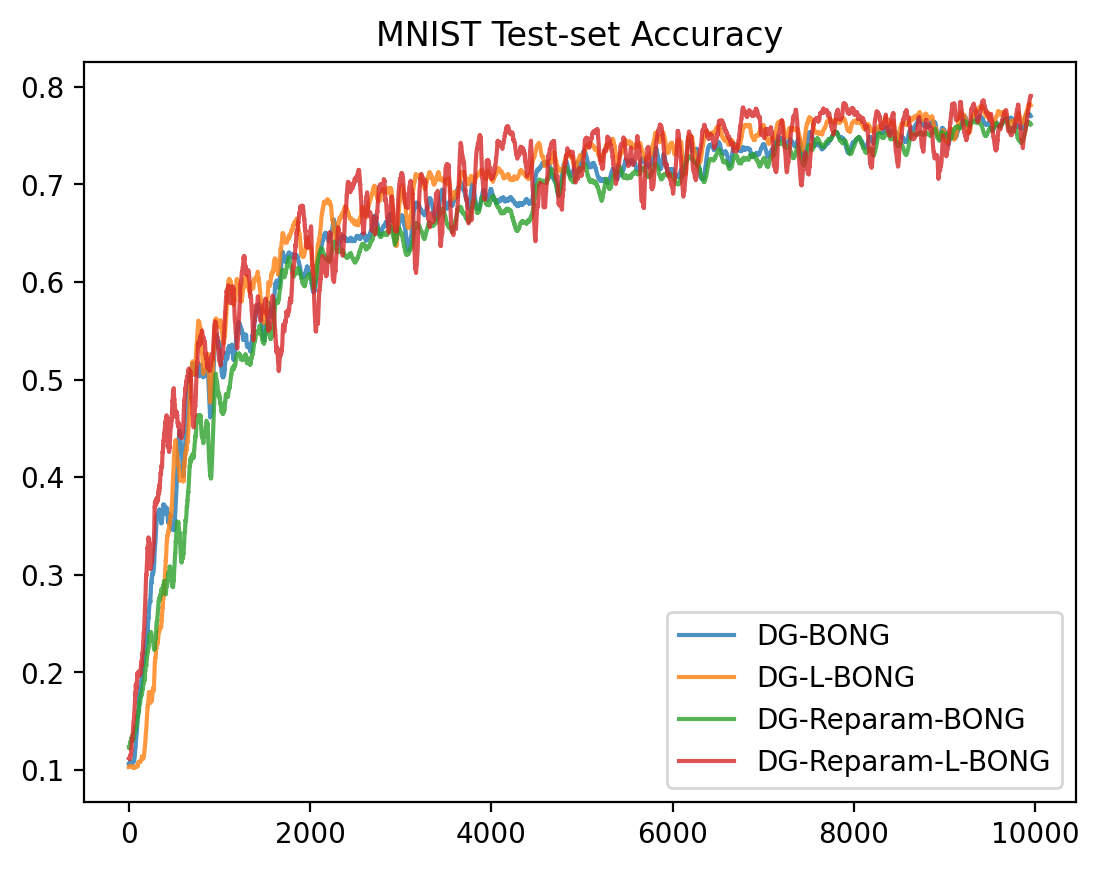

In [21]:
# Plot Accuracy
fig, ax = plt.subplots()
ax.plot(dg_acc_s, label="DG-BONG", alpha=0.8);
ax.plot(dgl_acc_s, label="DG-L-BONG", alpha=0.8);
ax.plot(dg_reparam_acc_s, label="DG-Reparam-BONG", alpha=0.8)
ax.plot(dgl_reparam_acc_s, label="DG-Reparam-L-BONG", alpha=0.8)
ax.legend()
ax.set_title("MNIST Test-set Accuracy");

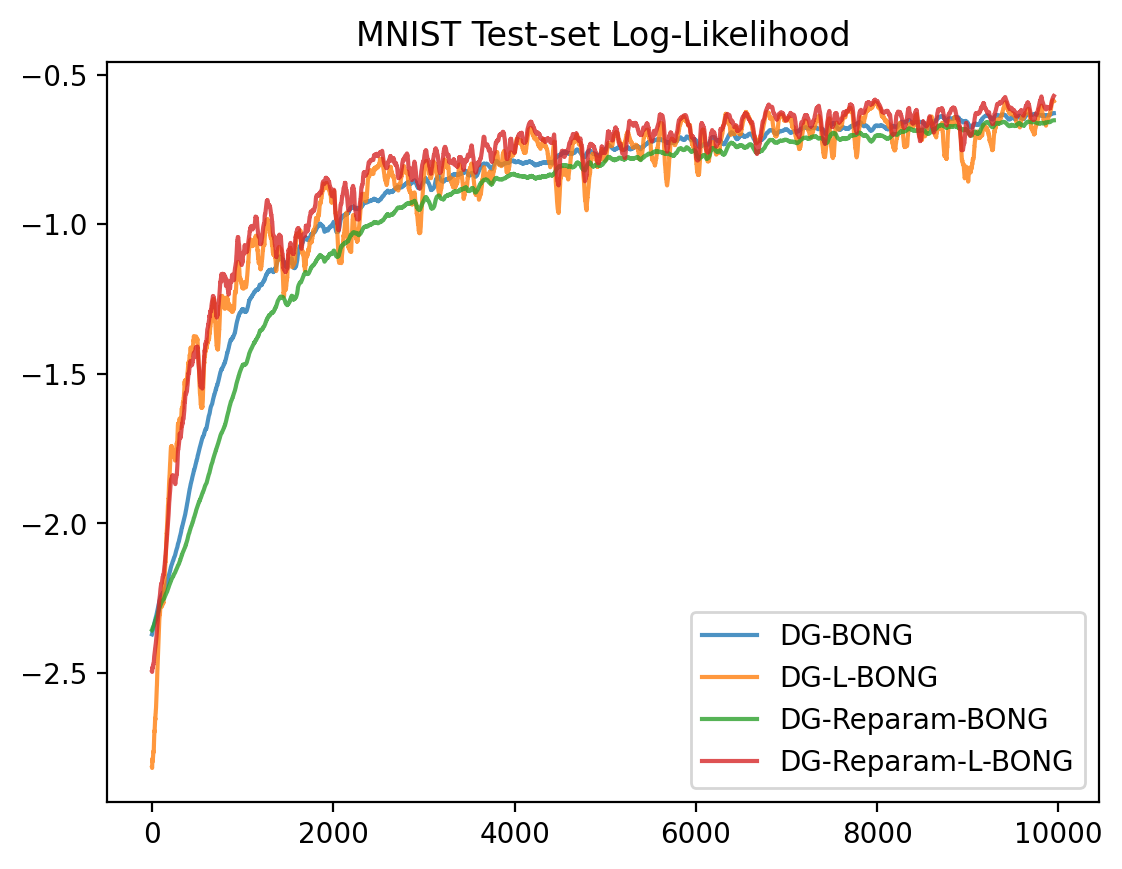

In [16]:
# Smoothed Log-Likelihoods
dg_ll_s = convolve_smooth(dg_ll)
dgl_ll_s = convolve_smooth(dgl_ll)
dg_reparam_ll_s = convolve_smooth(dg_reparam_ll)
dgl_reparam_ll_s = convolve_smooth(dgl_reparam_ll)

# Plot Log-Likelihood
fig, ax = plt.subplots()
ax.plot(dg_ll_s, label="DG-BONG", alpha=0.8);
ax.plot(dgl_ll_s, label="DG-L-BONG", alpha=0.8);
ax.plot(dg_reparam_ll_s, label="DG-Reparam-BONG", alpha=0.8)
ax.plot(dgl_reparam_ll_s, label="DG-Reparam-L-BONG", alpha=0.8)
ax.legend()
ax.set_title("MNIST Test-set Log-Likelihood");